## Running Time-Courses
Copasi enables users to simulate their model with a range of different solvers

### Create a model

In [7]:
import os
import site
site.addsitedir('D:\pycotools3')
from pycotools3 import model, tasks, viz

working_directory = r'/home/ncw135/Documents/pycotools3/docs/source/Tutorials/quick_start'
if not os.path.isdir(working_directory):
    os.makedirs(working_directory)
    
copasi_file = os.path.join(working_directory, 'michaelis_menten.cps')

if os.path.isfile(copasi_file):
    os.remove(copasi_file)
    
antimony_string = """
model michaelis_menten()
    compartment cell = 1.0
    var E in cell
    var S in cell
    var ES in cell
    var P in cell

    kf = 0.1
    kb = 1
    kcat = 0.3
    E = 75
    S = 1000

    SBindE: S + E => ES; kf*S*E
    ESUnbind: ES => S + E; kb*ES
    ProdForm: ES => P + E; kcat*ES
end
"""

with model.BuildAntimony(copasi_file) as loader:
    mm = loader.load(antimony_string)
    
    
mm

Model(name=michaelis_menten, time_unit=s, volume_unit=l, quantity_unit=mol)

Switching solvers required passing a string to the `method` argument which is `deterministic` by default.  

### Deterministic Time Course

In [10]:
TC = tasks.TimeCourse(
    mm, report_name='mm_simulation.txt',
    end=1000, intervals=50, step_size=20
)

## check its worked
os.path.isfile(TC.report_name)

import pandas
df = pandas.read_csv(TC.report_name, sep='\t')
df.head()

,Time,[E],[S],[ES],[P],Values[kf],Values[kb],Values[kcat]
0,0,75.00000,1000.000000,1.000000,1.000,0.1,1,0.3
1,20,2.00306,479.797000,73.996900,448.206,0.1,1,0.3
2,40,12.80010,62.104800,63.199900,876.695,0.1,1,0.3
3,60,75.13160,0.119830,0.868371,1001.010,0.1,1,0.3
4,80,75.99560,0.000604,0.004434,1001.990,0.1,1,0.3


.. note::

    When running a time course, you should ensure that the number of intervals times the step size equals the end time, i.e.: 
    
    - $intervals \cdot step\_size = end$

The default behaviour is to output all model variables as they can easily be filtered later in the Python environment. However, the `metabolites`, `global_quantities` and `local_parameters` arguments exist to filter the variables that are simulated prior to running the time course. 

In [15]:
TC=tasks.TimeCourse(
    mm,
    report_name='mm_timecourse.txt',
    end=1000,
    intervals=50,
    step_size=20,
    global_quantities = ['kf'],
)

##check that we only have two variables
pandas.read_csv(TC.report_name,sep='\t').head()

,Time,[E],[S],[ES],[P],Values[kf]
0,0,75.00000,1000.000000,1.000000,1.000,0.1
1,20,2.00306,479.797000,73.996900,448.206,0.1
2,40,12.80010,62.104800,63.199900,876.695,0.1
3,60,75.13160,0.119830,0.868371,1001.010,0.1
4,80,75.99560,0.000604,0.004434,1001.990,0.1


### Visualization

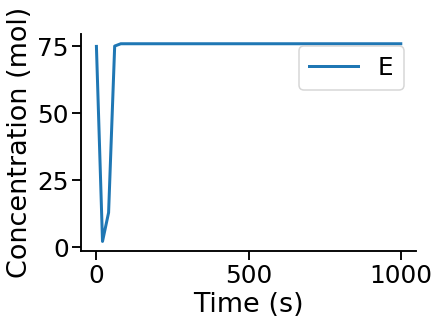

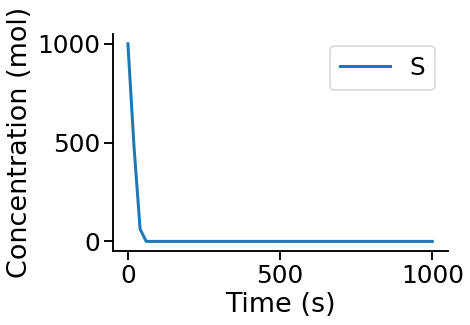

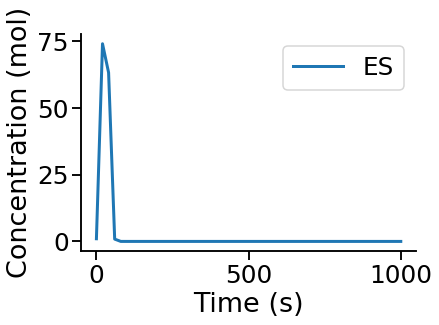

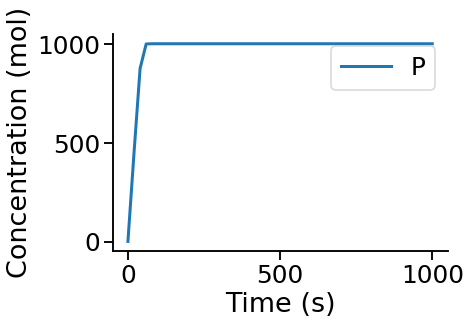

In [16]:
viz.PlotTimeCourse(TC)

It is also possible to plot these on the same axis by specifying `separate=False`

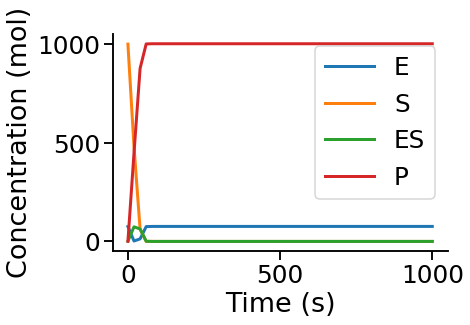

In [17]:
viz.PlotTimeCourse(TC, separate=False)

or to choose the y variables,

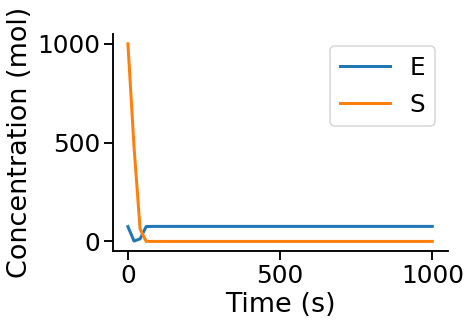

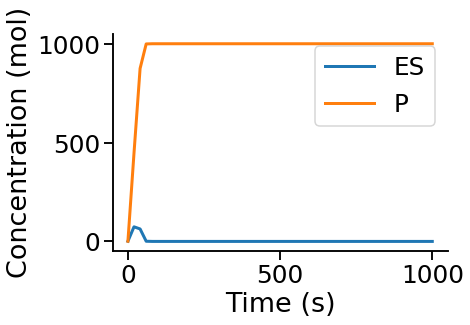

In [18]:
viz.PlotTimeCourse(TC, y=['E', 'S'], separate=False)
viz.PlotTimeCourse(TC, y=['ES', 'P'], separate=False)

#### Plot in Phase Space
Choose the x variable to plot phase space. Same arguments apply as above. 

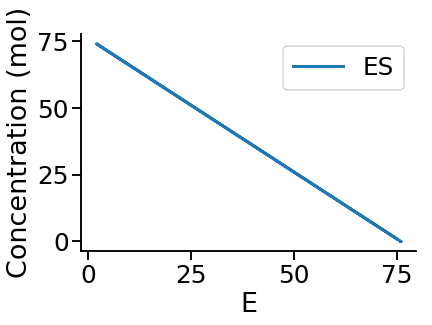

In [26]:
viz.PlotTimeCourse(TC, x='E', y='ES', separate=True)

#### Save to file
Use the `savefig=True` option to save the figure to file and give an argument to the filename option to choose the filename. 

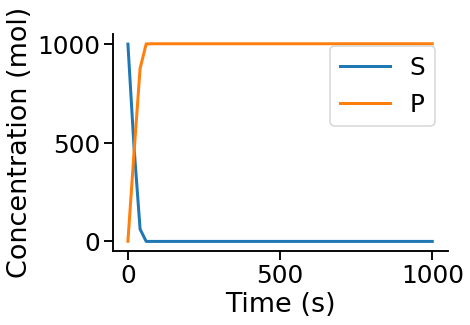

In [24]:
viz.PlotTimeCourse(TC, y=['S', 'P'], separate=False, savefig=True, filename='MyTimeCourse.png')

### Alternative Solvers
Valid arguments for the `method` argument of `TimeCourse` are:

    -  deterministic
    -  direct
    -  gibson_bruck
    -  tau_leap
    -  adaptive_tau_leap
    -  hybrid_runge_kutta
    -  hybrid_lsoda

Copasi also includes a `hybrid_rk45` solver but this is not yet supported by Pycotools. To use an alternative solver, pass the name of the solver to the `method` argument. 

#### Stochastic MM
For demonstrating simulation of stochastic time courses we build another michaelis-menten type reaction schema 

In [33]:
working_directory = r'/home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir'
copasi_file = os.path.join(working_directory, 'MichaelisMentenStochastic.cps')

if os.path.isfile(copasi_file):
    os.remove(copasi_file)

    
kf = 100
kb = 0.1
kcat = 0.05
E = 200
S = 1000
with model.Build(copasi_file) as m:
    m.name = 'Michaelis-Menten Stochastic'
    m.add('compartment', name='Cell', initial_value=1e-15)
    
    m.add('metabolite', name='P', particle_numbers=0)
    m.add('metabolite', name='S', particle_numbers=S)
    m.add('metabolite', name='E', particle_numbers=E)
    m.add('metabolite', name='ES', particle_numbers=0)
    
    m.add('reaction', name='S bind E', expression='S + E -> ES', rate_law='kf*S*E',
          parameter_values={'kf': kf})
    
    m.add('reaction', name='S unbind E', expression='ES -> S + E', rate_law='kb*ES',
         parameter_values={'kb': kb})

    m.add('reaction', name='ES produce P', expression='ES -> P + E', rate_law='kcat*ES', 
          parameter_values={'kcat': kcat})
    
stochastic_michaelis_menten = model.Model(copasi_file)
stochastic_michaelis_menten

Model(name=Michaelis-Menten Stochastic, time_unit=s, volume_unit=ml, quantity_unit=mmol)

### Run a Time Course Using Direct Method

In [34]:
TC = tasks.TimeCourse(stochastic_michaelis_menten, end=100, intervals=100, step_size=1, method='direct')

### Plot stochastic time course

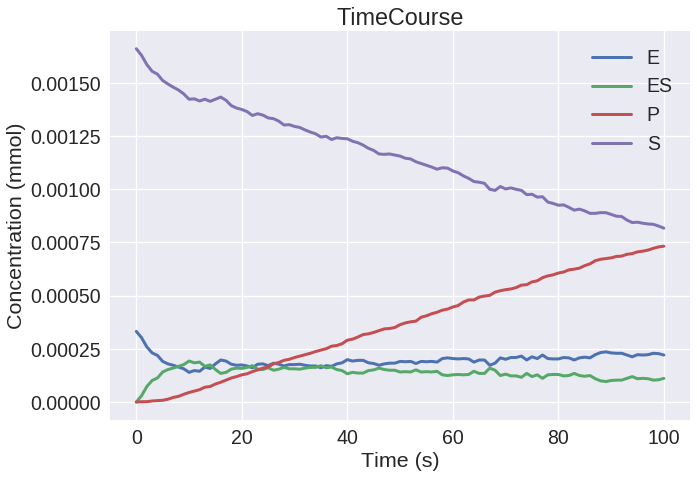

In [35]:
viz.PlotTimeCourse(TC, separate=False)